## 1 Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.dummy import DummyClassifier

### Знакомство с данными

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_advanced
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df['is_advanced'].value_counts()

0    2229
1     985
Name: is_advanced, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   calls        3214 non-null   float64
 1   minutes      3214 non-null   float64
 2   messages     3214 non-null   float64
 3   mb_used      3214 non-null   float64
 4   is_advanced  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод:**
1. Набор данных содержит 3214 строк и 5 столбцов. 
2. 4 столбца содержат вещественные числа, характеризующие поведение пользователей. Пятый столбец имеет целочисленный тип, в нем хранятся значения 0 и 1, характеризующие тариф, которым пользуется пользователь.
3. В данном наборе данных менее 1/3 строк относятся к тарифу продвинутый.
4. В наборе данных нет пропущенных значений.

### EDA

Перед построением моделей посмотрим на данные. Сравним использование звонков, минут, сообщений и интернета для пользователей двух тарифов. Для этого обратимся к гистограмме и диаграмме размаха.

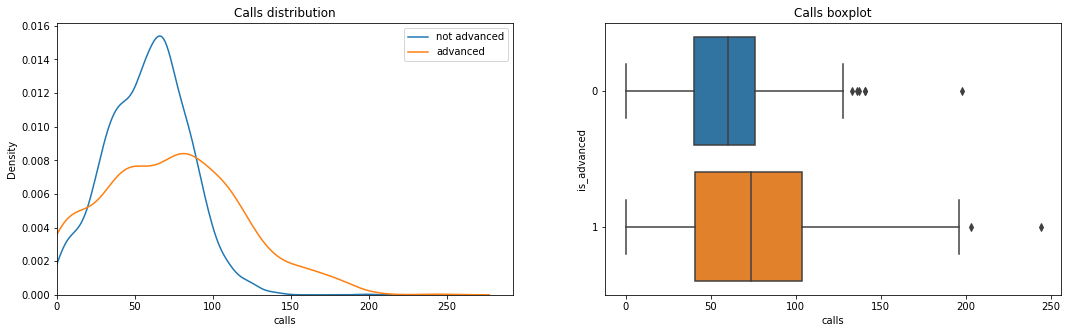

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.kdeplot(df.query('is_advanced == 0')['calls'], label='not advanced', ax=axes[0])
sns.kdeplot(df.query('is_advanced == 1')['calls'], label='advanced', ax=axes[0])
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(0,)
axes[0].set_title('Calls distribution')


sns.boxplot(x='calls', y='is_advanced', data=df, orient='h', ax=axes[1])
axes[1].set_title('Calls boxplot')
plt.show()

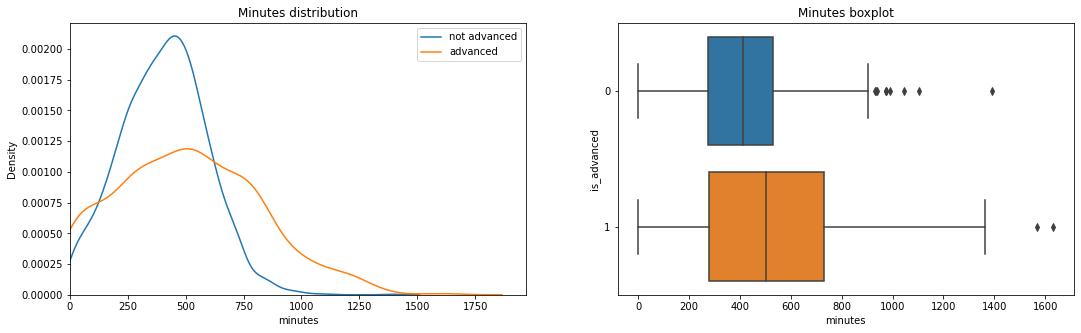

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.kdeplot(df.query('is_advanced == 0')['minutes'], label='not advanced', ax=axes[0])
sns.kdeplot(df.query('is_advanced == 1')['minutes'], label='advanced', ax=axes[0])
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(0,)
axes[0].set_title('Minutes distribution')


sns.boxplot(x='minutes', y='is_advanced', data=df, orient='h', ax=axes[1])
axes[1].set_title('Minutes boxplot')
plt.show()

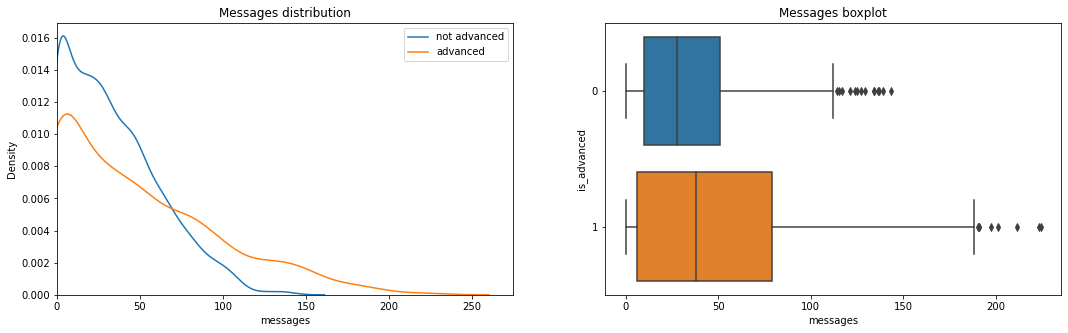

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.kdeplot(df.query('is_advanced == 0')['messages'], label='not advanced', ax=axes[0])
sns.kdeplot(df.query('is_advanced == 1')['messages'], label='advanced', ax=axes[0])
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(0,)
axes[0].set_title('Messages distribution')


sns.boxplot(x='messages', y='is_advanced', data=df, orient='h', ax=axes[1])
axes[1].set_title('Messages boxplot')
plt.show()

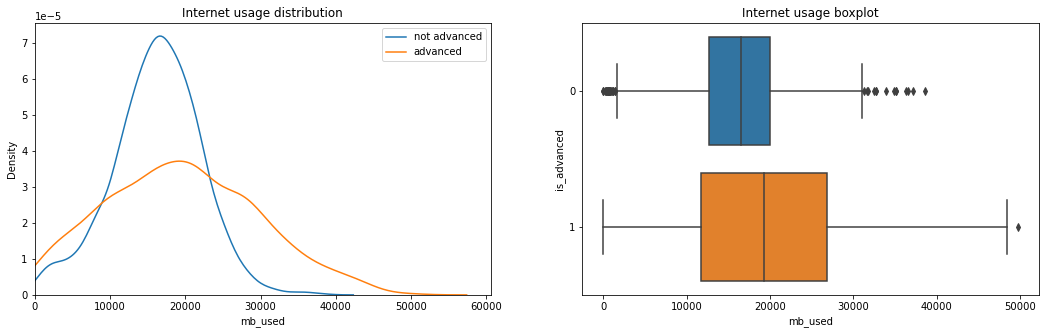

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.kdeplot(df.query('is_advanced == 0')['mb_used'], label='not advanced', ax=axes[0])
sns.kdeplot(df.query('is_advanced == 1')['mb_used'], label='advanced', ax=axes[0])
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(0,)
axes[0].set_title('Internet usage distribution')


sns.boxplot(x='mb_used', y='is_advanced', data=df, orient='h', ax=axes[1])
axes[1].set_title('Internet usage boxplot')
plt.show()

**Вывод:**
1. Пользователи тарифа ультра в среднем используют больше минут, смс и интернет трафика.
2. Пользователи тарифа ультра более склонны к экстремальным значениям использования мобильной связи.

## Разбиение данных на выборки

In [10]:
features = df.drop('is_advanced', axis=1)
target = df['is_advanced']

Для настройки гиперпараметров моделей нужна выборка валидации, а для оценки поведения модели нужна тестовая выборка. Следовательно изначальный набор данных нужно разбить на 3 части - тестовую, валидационную и обучающую. Однако для настройки гиперпараметров я буду использовать технику GridSearch в комбинации с кросс-валидацией, данная техника доступна в библиотеке sklearn, валидационная выборка будет выделяться из обучающей автоматически. Таким образом разделим изначальный датасет на обучающую и тестовую выборки. Пусть тестовая выборка будет 20%.

In [25]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2,
                                                                            stratify=target,
                                                                            random_state=42)

Выполним проверку.

In [28]:
features_train.shape

(2571, 4)

In [29]:
features_test.shape

(643, 4)

In [30]:
target_train.shape

(2571,)

In [31]:
target_test.shape

(643,)

Разбиение произведено успешно.

## Исследование моделей

Сначала создадим все модели, затем, используя технику GridSearch, проведем оптимизацию гиперпараметров, а затем выберем лучшую модель. 

Будем исследовать четыре модели: логистическую регрессию, метод к-ближайщих соседей, дерево решений и случайный лес.

### Логистическая регрессия

В данной моделе будем настраивать параметр С, который отвечает за регуляризацию. Чем выше С, тем слабее регуляризация. Кросс-валидацию проведем с 5 фолдами, что означает, что каждую итерацию 20% от обучающей выборки будет использовано в качестве валидационной выборки.

In [32]:
parameters = [{'C' : [0.1, 0.5, 1, 1.5, 2, 5, 10, 15, 20, 25, 50]}]
grid_search = GridSearchCV(estimator=LogisticRegression(solver='liblinear', random_state=42),
                           param_grid=parameters,
                           cv=5,
                           verbose=1)
grid_search.fit(features_train, target_train)
best_acc_lr = grid_search.best_score_
best_parameters_lr = grid_search.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


In [33]:
print('Best Accuracy: {:.3f}'.format(best_acc_lr))
print('Best Parameters:', best_parameters_lr)

Best Accuracy: 0.716
Best Parameters: {'C': 1.5}


Обучим модель на обучающей выборке, используя оптимальные гиперпараметры.

In [34]:
log_reg_opt = LogisticRegression(C=1.5, random_state=42)
log_reg_opt.fit(features_train, target_train)

LogisticRegression(C=1.5, random_state=42)

**Вывод:**
1. Настройка гиперпараметров показала, что наилучшим параметром С является 0.1. 
2. Точность предсказаний составляет 0.716.

### Метод к-ближайших соседей

В данной модели калибровать будем количество соседей, по которым модель будет определять класс объекта.

In [35]:
parameters = [{'n_neighbors' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]}]
grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                           param_grid=parameters,
                           cv=5,
                           verbose=1)
grid_search.fit(features_train, target_train)
best_acc_knn = grid_search.best_score_
best_parameters_knn = grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [36]:
print('Best Accuracy: {:.3f}'.format(best_acc_knn))
print('Best Parameters:', best_parameters_knn)

Best Accuracy: 0.764
Best Parameters: {'n_neighbors': 15}


Обучим модель с оптимальными гиперпараметрами.

In [37]:
knn_opt = KNeighborsClassifier(n_neighbors=15)
knn_opt.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=15)

**Вывод:**
1. Настройка гиперпараметров показала, что наилучшим числом соседей является 15 соседей. 
2. Точность предсказаний составляет 0.764.

### Дерево решений

В данном случае будем оптимизировать параметр глубины и минимального количества наблюдений, необходимого для разбиения узла.

In [38]:
parameters = [{'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50], 
               'min_samples_split': [2, 3, 4, 5, 6, 7, 8]}]
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=parameters,
                           cv=5,
                           verbose=1)
grid_search.fit(features_train, target_train)
best_acc_tree = grid_search.best_score_
best_parameters_tree = grid_search.best_params_

Fitting 5 folds for each of 91 candidates, totalling 455 fits


In [39]:
print('Best Accuracy: {:.3f}'.format(best_acc_tree))
print('Best Parameters:', best_parameters_tree)

Best Accuracy: 0.792
Best Parameters: {'max_depth': 5, 'min_samples_split': 2}


Обучим модель, используя оптимальные гиперпараметры.

In [40]:
tree_classifier_opt = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_classifier_opt.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

**Вывод:**
1. Настройка гиперпараметров показала, что наилучшей глубиной является 5, а наилучшее минимальное количество для разбиения - 2 (что является значением по умолчанию).
2. Точность предсказаний составляет 0.792.

### Случайный лес

В данном случае калибруем количество деревьев и максимальную глубину.

In [41]:
parameters = [{'n_estimators' : [1, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200],
               'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}]
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=parameters,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(features_train, target_train)
best_acc_rf = grid_search.best_score_
best_parameters_rf = grid_search.best_params_

Fitting 5 folds for each of 121 candidates, totalling 605 fits


In [42]:
print('Best Accuracy: {:.3f}'.format(best_acc_rf))
print('Best Parameters:', best_parameters_rf)

Best Accuracy: 0.813
Best Parameters: {'max_depth': 9, 'n_estimators': 20}


Обучим модель на обучающей выборке с использованием оптимальных гиперпараметров. 

In [43]:
rf_classifier_opt = RandomForestClassifier(n_estimators=20, max_depth=9, random_state=42)
rf_classifier_opt.fit(features_train, target_train)

RandomForestClassifier(max_depth=9, n_estimators=20, random_state=42)

**Вывод:**
1. Настройка гиперпараметров показала, что наилучшей глубиной является 9, а наилучшее количество деревьев - 20.
2. Точность предсказаний составляет 0.813.

### Сравнение моделей

Сведем полученные результаты для разных моделей в одну таблицу.

In [44]:
pd.Series(data=[best_acc_lr, best_acc_knn, best_acc_tree, best_acc_rf], 
          index=['logistic_regression', 'knn', 'decision_tree', 'random_forest'],
          name='model performance').to_frame()

,model performance
logistic_regression,0.716060
knn,0.764302
decision_tree,0.791528
random_forest,0.812534


Из полученных результатов видно, что лучше всех себя показала модель случайного леса, а хуже всех - логистическая регрессия.

### Вывод

1. 4 модели машинного обучения были исследованы на обучающей выборке - логистическая регрессия, метод к-ближайших соседей, дерево решений и случайный лес.
2. Техника GridSearch в комбинации с кросс-валидацией была использована для оптимизации гиперпараметров. 
3. Худшую точность предсказаний показала логистическая регрессия, лучшую - случайный лес. 

## Проверка на тестовой выборке

Проверим все модели на тестовой выборке. Для оценки качества моделей будем использовать метрику **accuracy**.

### Логистическая регрессия

In [45]:
target_predicted_lr = log_reg_opt.predict(features_test)

In [46]:
accuracy_lr = accuracy_score(target_test, target_predicted_lr)
accuracy_lr

0.7387247278382582

Доля правильных ответов - 73.9%.

### Метод к-ближайших соседей

In [47]:
target_predicted_knn = knn_opt.predict(features_test)

In [48]:
accuracy_knn = accuracy_score(target_test, target_predicted_knn)
accuracy_knn

0.776049766718507

Доля правильных ответов - 77.6%.

### Дерево решений

In [49]:
target_predicted_tree = tree_classifier_opt.predict(features_test)

In [50]:
accuracy_tree = accuracy_score(target_test, target_predicted_tree)
accuracy_tree

0.7713841368584758

Доля правильных ответов - 77.1%.

### Случайный лес

In [51]:
target_predicted = rf_classifier_opt.predict(features_test)

In [52]:
accuracy_forest = accuracy_score(target_test, target_predicted)
accuracy_forest

0.8258164852255054

Доля правильных ответов - 82.6%.

### Вывод

Сведем полученные результаты в одну таблицу. Также добавим данные по валидации, полученные в предыдущем пункте.

In [53]:
pd.DataFrame(data=[['logistic_regression', best_acc_lr, accuracy_lr], ['knn', best_acc_knn, accuracy_knn], ['decision_tree', best_acc_tree, accuracy_tree], ['random_forest', best_acc_rf, accuracy_forest]], 
          columns=['model', 'validation', 'test'])

,model,validation,test
0,logistic_regression,0.716060,0.738725
1,knn,0.764302,0.776050
2,decision_tree,0.791528,0.771384
3,random_forest,0.812534,0.825816


Рассчитаем дополнительные метрики для самой успешной модели (для модели случайного леса). Сначала посмотрим на матрицу ошибок.

In [54]:
confusion_matrix(target_test, target_predicted)

array([[428,  18],
       [ 94, 103]], dtype=int64)

В 428 случаях модель корректно определила то, что пользователь не использует тариф "Продвинутый". В 103 корректно определила, что пользователь использует тариф "Продвинутый". В 18 случаях модель предсказала тариф "Продвинутый", однако пользователь им не пользовался, это False Positive. И в 94 случаях модель предсказала, что пользователь не использует "Продвинутый", но ошиблась, это False Negative. Посмотрим дополнительно на *precision* и *recall*.

In [55]:
precision_score(target_test, target_predicted)

0.8512396694214877

Данное значение говорит нам о том, что в 85% случаев, когда модель говорит, что данному пользователю подойдет тариф "Продвинутый", она верна.

In [56]:
recall_score(target_test, target_predicted)

0.5228426395939086

Данное значение говорит о том, что если пользователю подойдет тариф "Продвинутый", модель сможет определит это с вероятностью в 52%.

**Вывод:**

1. Все модели с оптимальными параметрами были протестированы на тестовой выборке.
2. Поведением моделей не ухудшилось на тестовой выборке (за исключением решающего дерева).
3. Лучше всего себя показал случайный лес, хуже всех - логистчиеская регрессия.

## Проверька модели на адекватность

Для проверки будем использовать DummyClassifier из библиотеки scikit-learn. Данный классификатор проводит классификацию по простейшим правилам.

Одним из таких правил является предсказание наиболее часто встречающегося класса. Создадим такой классификатор.

In [57]:
dummy_class = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_class.fit(features_train, target_train)
dummy_predicted = dummy_class.predict(features_test)
accuracy_score(target_test, dummy_predicted)

0.6936236391912908

69% точных предсказаний, если просто всегда предсказывать наиболее часто встречаемый класс в обучающей выборке. В наших моделях точность предсказаний выше.

Посмотрим на поведение классификатора, который делает предсказания случайно.

In [58]:
dummy_class = DummyClassifier(strategy='uniform', random_state=42)
dummy_class.fit(features_train, target_train)
dummy_predicted = dummy_class.predict(features_test)
accuracy_score(target_test, dummy_predicted)

0.49144634525660963

Как и ожидалось, его точность лежит в районе 50%. 

**Вывод:**
1. Модель можно считать адекватной, так как она ведет себя лучше константной модели.